# Sequential

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(10000)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 640,714
Trainable params: 640,714
Non-trainable params: 0
_________________________________________________________________


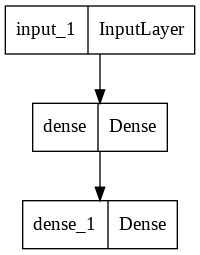

In [ ]:
keras.utils.plot_model(model)

# Functional

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(10000))
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features) 
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_2 (Dense)             (None, 64)                640064    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 640,714
Trainable params: 640,714
Non-trainable params: 0
_________________________________________________________________


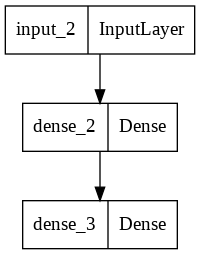

In [ ]:
keras.utils.plot_model(model)

# Functional 2

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title") 
text_body = keras.Input(shape=(vocabulary_size,), name="text_body") 
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

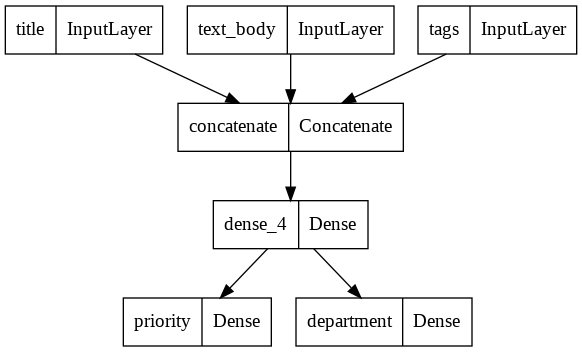

In [ ]:
keras.utils.plot_model(model)

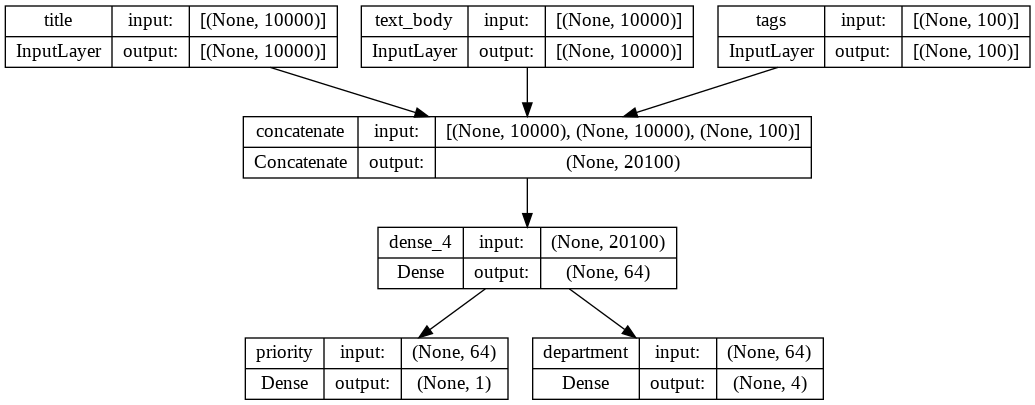

In [ ]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

In [ ]:
import numpy as np 

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [ ]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"], 
              metrics=[["mean_absolute_error"], ["accuracy"]])

In [ ]:
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)

40/40 [==============================] - 2s 20ms/step - loss: 39.5430 - priority_loss: 0.3365 - department_loss: 39.2066 - priority_mean_absolute_error: 0.5044 - department_accuracy: 0.2414


In [ ]:
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])

40/40 [==============================] - 1s 10ms/step - loss: 10.0463 - priority_loss: 0.3403 - department_loss: 9.7060 - priority_mean_absolute_error: 0.5085 - department_accuracy: 0.1242


[10.04625415802002,
 0.3402731120586395,
 9.705982208251953,
 0.5085012912750244,
 0.12421874701976776]

In [ ]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 8ms/step


### Another way to compile, fit, evaluate, and predict

In [ ]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", 
                    "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], 
                       "department": ["accuracy"]})
model.fit({"title": title_data, 
           "text_body": text_body_data,
           "tags": tags_data},
          {"priority": priority_data, 
           "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, 
                "text_body": text_body_data,
                "tags": tags_data},
               {"priority": priority_data, 
                "department": department_data}) 
priority_preds, department_preds = model.predict({"title": title_data, 
                                                  "text_body": text_body_data, 
                                                  "tags": tags_data})

40/40 [==============================] - 0s 8ms/step


# Subclassing

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
import numpy as np 

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

In [12]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [13]:
model = CustomerTicketModel(num_departments=4)

priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [14]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 0s 8ms/step


# Functional model that includes a subclassed model

In [ ]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

 # Subclassed model that includes a Functional model

In [ ]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()